Customer – Wants to see products that matches his needs
Business – Needs to show product that are more likely to buy
Solution – Categorize customers that are more likely to click on the displayed product search result. 
A machine learning model that accurately predicts the customer category based on features sampled from various criteria depicting the usage of the app by the customer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import missingno as msno

np.random.seed(42)

In [2]:
train = pd.read_csv('../input/amazhr/train.csv')
test = pd.read_csv('../input/amazhr/test.csv')

train_d = train.drop(columns=['customer_category','customer_id'])

In [3]:
train.head()

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
0,csid_1,13.168425,9.447662,-0.070203,-0.139541,0.436956,4.705761,2.537985,7.959503,C,F,0
1,csid_2,17.092979,7.329056,0.153298,-0.102726,0.380340,4.205138,4.193444,17.517381,C,A,0
2,csid_3,17.505334,5.143676,0.106709,0.262834,0.417648,4.479070,3.878971,12.595155,C,BA,0
3,csid_4,31.423381,4.917740,-0.020226,-0.100526,0.778130,5.055535,2.708940,4.795073,AA,F,0
4,csid_5,11.909502,4.237073,0.187178,0.172891,0.162067,3.445247,3.677360,56.636326,C,AA,0


It looks like we have some categorical information. Let's dive into each feature importance.

# Data Analysis

## Customer Category

It seems that the data we have is heavily imbalanced. Also the distribution of data is even for customer category - 0 but not so for the latter. It can be inferred from the results that the data is heavily imbalanced. This means that we are very selective of the customers to whom we show our product suggestions. 

To deal with data imbalance, we will follow the following techniques.
* Minority data oversampling - As the available data is less with us and we can't afford to ignore any training data
* Change our classification metric to "Precision" instead of mere "Accuracy Score"



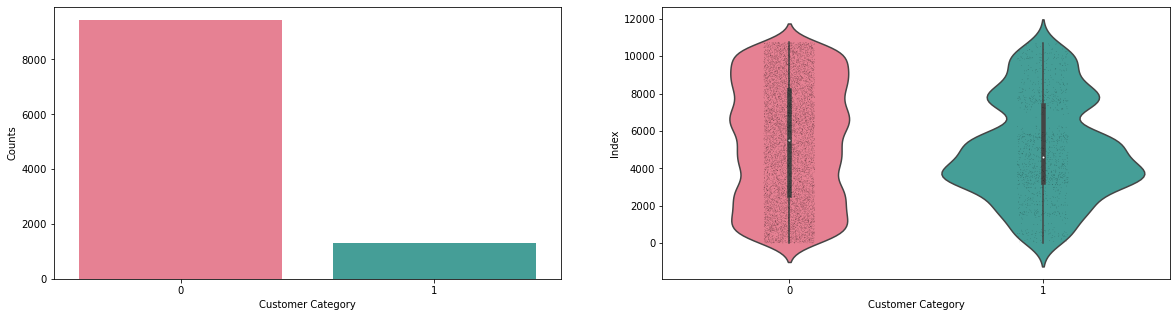

In [4]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(train.customer_category.values,ax=ax[0],palette='husl')
sns.violinplot(x=train.customer_category.values, y=train.index.values, ax=ax[1], palette="husl")
sns.stripplot(x=train.customer_category.values, y=train.index.values,
              jitter=True, ax=ax[1], color="black", size=0.5, alpha=0.5)

ax[0].set_xlabel("Customer Category")
ax[0].set_ylabel("Counts")
ax[1].set_xlabel("Customer Category")
ax[1].set_ylabel("Index")
fig.savefig("category.png")

## Categorical Features

In [5]:
s = (train_d.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:",object_cols)

Categorical variables: ['customer_active_segment', 'X1']


## Missing Values

In [6]:
missing_values_count = train.isnull().sum()
missing_values_count=missing_values_count.sort_values(ascending=False)
missing_values_count= missing_values_count[missing_values_count!=0]
print (missing_values_count)

customer_order_score                66
customer_product_variation_score    46
customer_product_search_score       42
X1                                  37
customer_stay_score                 37
customer_active_segment             23
dtype: int64


<Figure size 432x288 with 0 Axes>

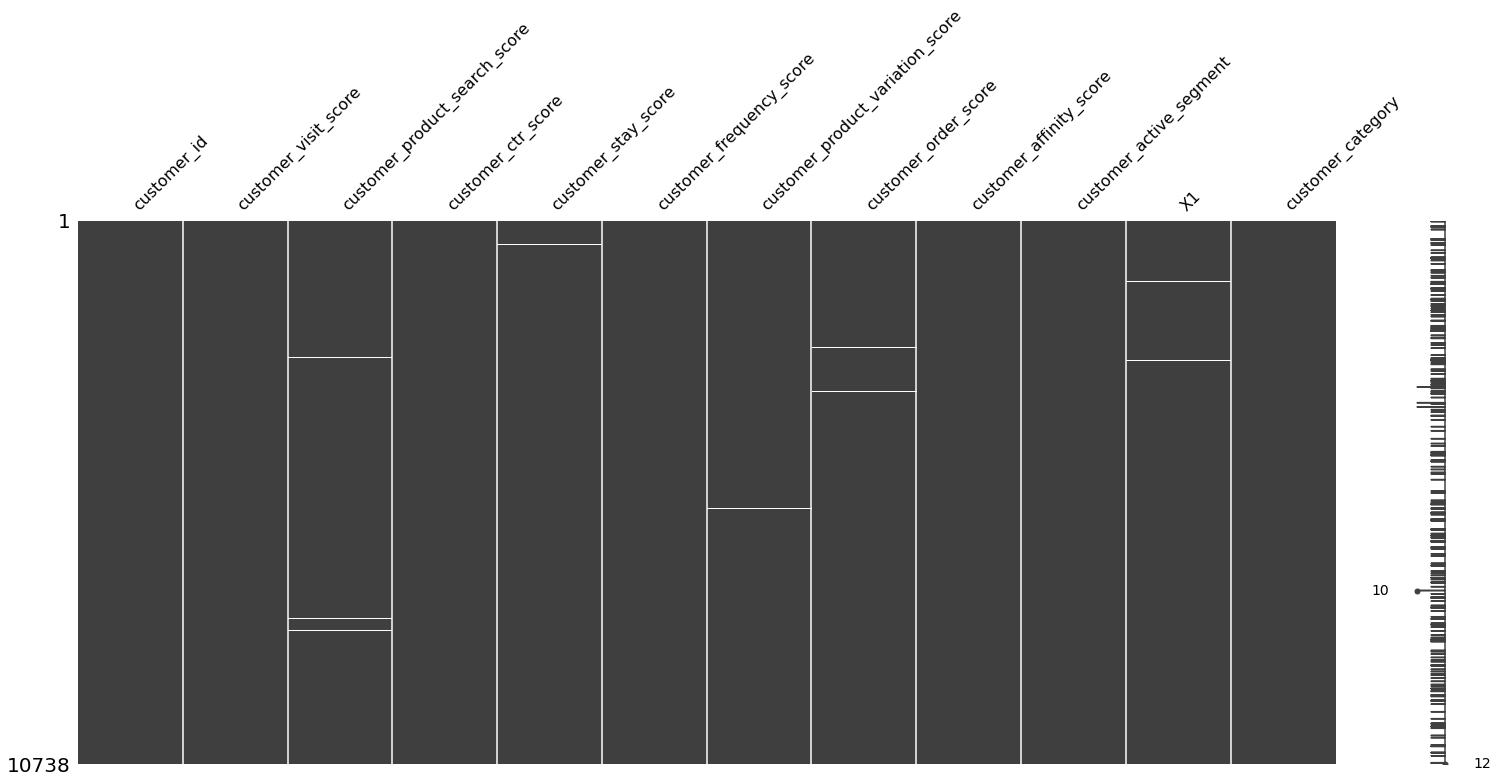

In [7]:
fig = plt.figure()
msno.matrix(train)
fig.savefig("missing.png")

* The data is heavily imbalanced.
* There are numerical features as well as categorical features in our dataset.
* Some of the features have missing values. 

Let’s analyze each feature independently and fix above problems. 


In [8]:
# A basic function that plots the features distribution and its correlation with other features
def plot_corr_hist(feature):
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    sns.heatmap(train.corr()[[feature]], ax=ax[0],annot=True, cmap="RdYlGn", annot_kws={"size":15})
    train[feature].hist(bins=30,color='blue',ax=ax[1],alpha=0.7)
    fig.savefig(feature+".png")

# Feature Analysis

## Customer Visit Score

A score based on how regularly the customer visits the website. We don't have any missing data for this feature. The distribution seems to be uniform. As the score is very noisy, and uniformly distributed we can categorise the distribution into 10 bins which we will do during data cleaning.


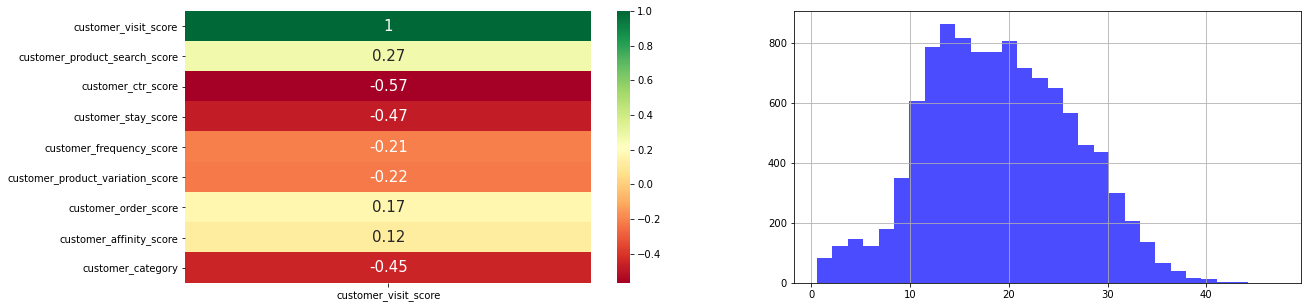

In [9]:
plot_corr_hist("customer_visit_score")

## Customer Product Search Score

Quality or price range of product that the customer searches for. The distribution seems to be following  a nice normal distribution and there is not much of significant correlation. So, in order to fill the missing values we will use random samples generated from the distribution.

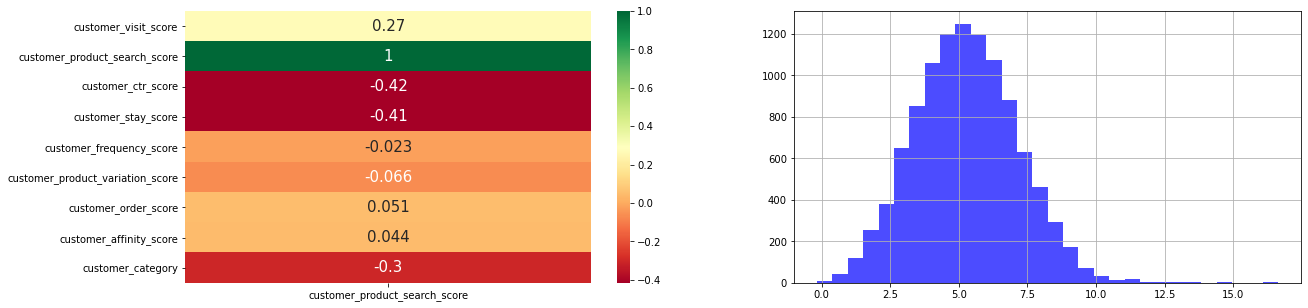

In [10]:
plot_corr_hist("customer_product_search_score")

## Customer Ctr Score & Customer Stay Score

**Ctr Score :** How many of the searched links does the customer click.

**Stay Score:** A score based on the time spent on an avg. by the customer.
* As expected, both these features are heavily correlated because customer that stays more time on the app tend to click the searched links at some point of time. 
* We have a few missing values in Customer stay score which we will fix by using KNNImputer based on Ctr Score as they are correlated. 

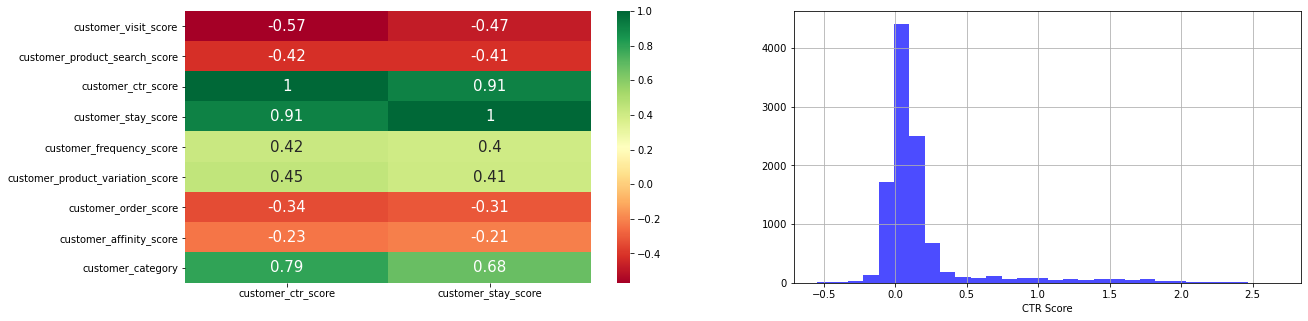

In [11]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.heatmap(train.corr()[["customer_ctr_score","customer_stay_score"]], ax=ax[0],annot=True, cmap="RdYlGn", annot_kws={"size":15})
train["customer_ctr_score"].hist(bins=30,color='blue',ax=ax[1],alpha=0.7)
plt.xlabel("CTR Score")
fig.savefig("ctr"+".png")

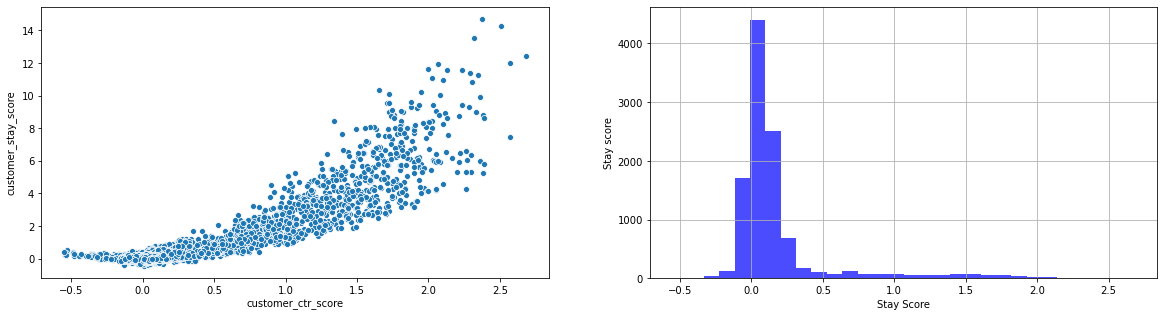

In [12]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.scatterplot(train["customer_ctr_score"], train["customer_stay_score"],ax=ax[0]);
plt.xlabel("CTR Score")
plt.ylabel("Stay score")
train["customer_ctr_score"].hist(bins=30,color='blue',ax=ax[1],alpha=0.7)
plt.xlabel("Stay Score")
fig.savefig("stay.png")

# Other features

Similiar analysis can be done on rest of the features as well. 

* Frequency Score – Frequency of customers visit to the website
* Product variation score – Score based on the variety of products seen by customer.
* Order score – Reliability of customer in not returning the order.
* Affinity Score – Customers affinity to the website.


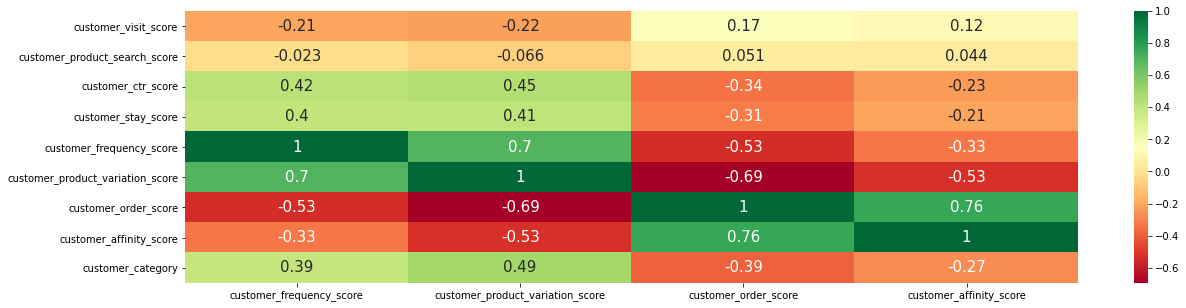

In [13]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.heatmap(train.corr()[["customer_frequency_score","customer_product_variation_score","customer_order_score","customer_affinity_score"]],ax=ax,annot=True,cmap="RdYlGn", annot_kws={"size":15})
fig.savefig("corr.png")

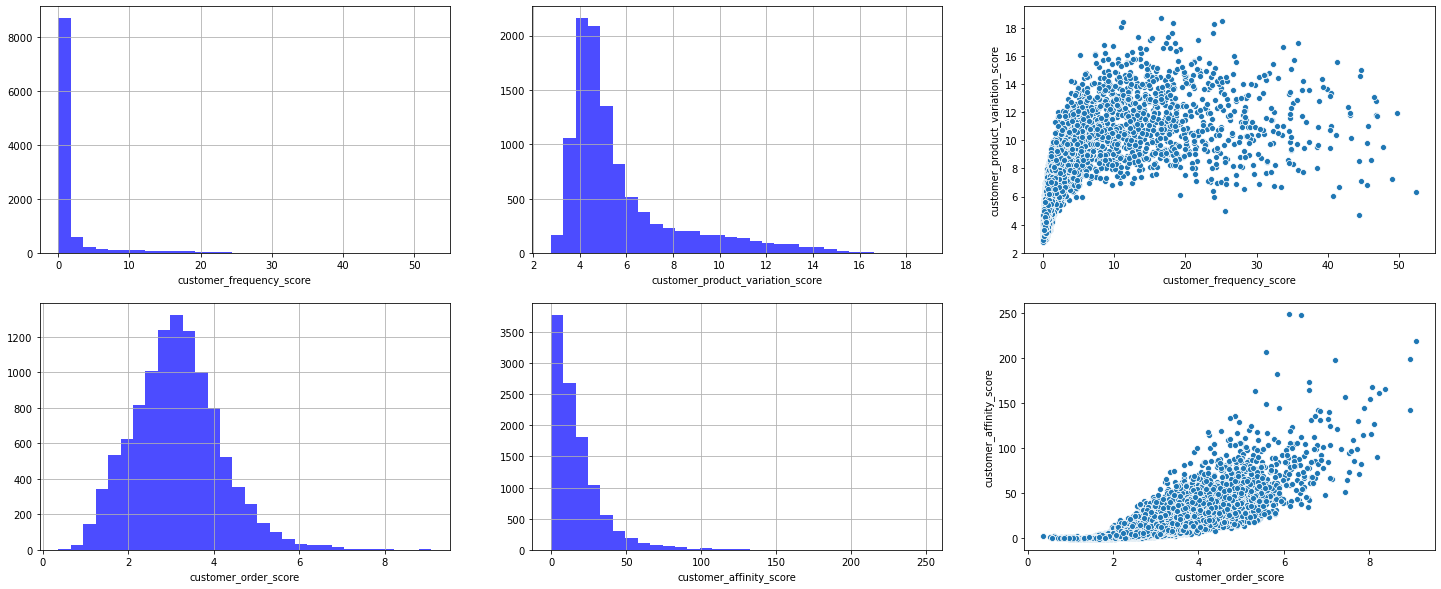

In [14]:
fig, ax = plt.subplots(2,3,figsize=(25,10))
train["customer_frequency_score"].hist(bins=30,color='blue',ax=ax[0][0],alpha=0.7)
ax[0][0].set_xlabel("customer_frequency_score")
train["customer_product_variation_score"].hist(bins=30,color='blue',ax=ax[0][1],alpha=0.7)
ax[0][1].set_xlabel("customer_product_variation_score")
sns.scatterplot(train["customer_frequency_score"], train["customer_product_variation_score"],ax=ax[0][2]);
ax[0][2].set_xlabel("customer_frequency_score")
ax[0][2].set_ylabel("customer_product_variation_score")
train["customer_order_score"].hist(bins=30,color='blue',ax=ax[1][0],alpha=0.7)
ax[1][0].set_xlabel("customer_order_score")

train["customer_affinity_score"].hist(bins=30,color='blue',ax=ax[1][1],alpha=0.7)
ax[1][1].set_xlabel("customer_affinity_score")
sns.scatterplot(train["customer_order_score"], train["customer_affinity_score"],ax=ax[1][2]);
ax[1][2].set_xlabel("customer_order_score")
ax[1][2].set_ylabel("customer_affinity_score")
fig.savefig("other.png")

* Frequency and Product Variation scores, Order and Affinity scores are positively correlated. 
* From the scatter plots, for frequency and product variation score, we can infer that the scores are densely packed to the lower end because they have a positive correlation in predicting the customer category.
* As expected, order score has a negative correlation with our customer category, because we don’t want to show our products to customers that are more likely to return it back.
* For handling missing values in Order score, random scores are sampled from its distribution. In product variation score, an iterative imputer called Mice Imputer is used that fills the missing values by modelling the current feature on rest of the features iteratively.


# Categorical Features

* Two categorical features, Active Segment and X1
* Not much information about how they are calculated or what each of the category signifies.
* But it can be inferred that some categories are more likely to be classified as Type 1 customer than other.
* Also, it was found that all the rows with missing values correspond to Type 0 customer.
* So, filled all the missing values in these features with a dummy variable.


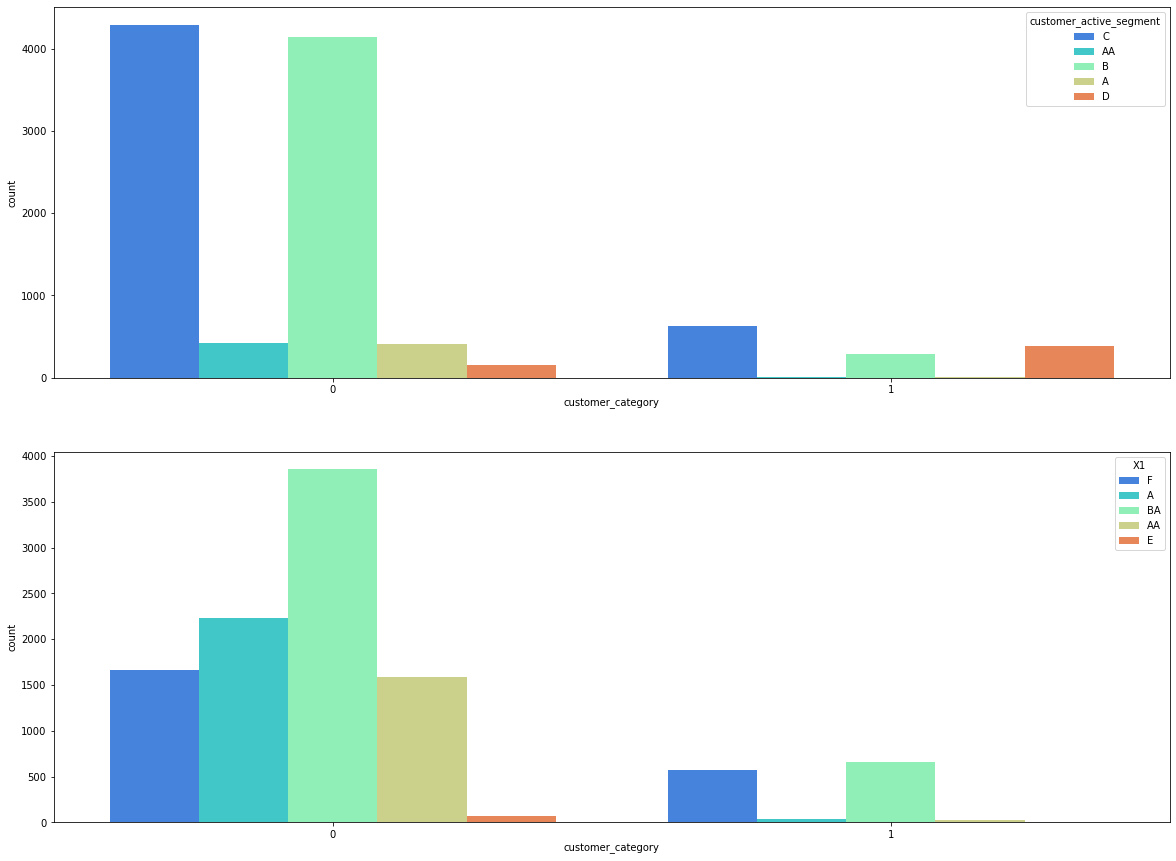

In [15]:
train_c = train[["customer_active_segment","customer_category","X1"]]
train_c.fillna("Z")
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.countplot(x='customer_category',hue='customer_active_segment',ax=ax[0],data=train_c,palette='rainbow')
sns.countplot(x='customer_category',hue='X1',data=train_c,ax=ax[1],palette='rainbow')
fig.savefig("cat.png")

# Handling Missing Values and Data Cleaning

## Fill With Random Samples
Filling With Random values sampled from the range mean - std, mean+std.  "customer_product_search_score" and "customer_order_score" seem to have good normal distribution. So, we use this method to fill in the missng values in those.

In [16]:

mean = train["customer_product_search_score"].mean()
std = train["customer_product_search_score"].std()
null_count = train["customer_product_search_score"].isnull().sum()
rand_train = np.random.randint(mean - std, mean + std, size = null_count)
null_count_t= test["customer_product_search_score"].isnull().sum()
rand_test = np.random.randint(mean - std, mean + std, size = null_count_t)
train["customer_product_search_score"][train["customer_product_search_score"].isnull()]=rand_train
test["customer_product_search_score"][test["customer_product_search_score"].isnull()]=rand_test



mean = train["customer_order_score"].mean()
std = train["customer_order_score"].std()
null_count = train["customer_order_score"].isnull().sum()
rand_train = np.random.randint(mean - std, mean + std, size = null_count)
null_count_t= test["customer_order_score"].isnull().sum()
rand_test = np.random.randint(mean - std, mean + std, size = null_count_t)
train["customer_order_score"][train["customer_order_score"].isnull()]=rand_train
test["customer_order_score"][test["customer_order_score"].isnull()]=rand_test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value 

## KNN Imputer
"customer_stay_score" is highly correlated with "customer_ctr_score". So, we use a KNN imputer to fill in the missing values based on the K-Nearest Neighbours from "customer_ctr_score".

In [17]:
from sklearn.impute import KNNImputer

train_knn = train[["customer_ctr_score","customer_stay_score"]]

knn_imputer = KNNImputer(n_neighbors=3, weights="uniform")
train_knn['customer_stay_score'] = knn_imputer.fit_transform(train_knn[['customer_stay_score']])
train["customer_stay_score"]=train_knn['customer_stay_score']
test["customer_stay_score"] = knn_imputer.transform(test[["customer_stay_score"]])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Mice Imputer 
For filling in missing values of "customer_product_variation_score" we use Mice imputer which fill in missing values based on normal sampling from te rest of the features.

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

mice_imputer = IterativeImputer()
train['customer_product_variation_score'] = mice_imputer.fit_transform(train[['customer_product_variation_score']])
test["customer_product_variation_score"]= mice_imputer.transform(test[["customer_product_variation_score"]])

## Probability with Target Variable
For "customer_active_segment" and "X1" score, columns with missing values correspond to Customer Category - 0. So, we fill their respective missing values with columns that are values that are classified as 0 with most probability.

In [19]:
train["customer_active_segment"]=train["customer_active_segment"].fillna("A")
train["X1"]=train["X1"].fillna("E")
test["customer_active_segment"]=test["customer_active_segment"].fillna("A")
test["X1"]=test["X1"].fillna("E")

## Data Cleaning 

## Sampling based on distribution 
For the numerical features, we do quantile cuts and uniform cuts and later label them with the mean value of the interval. 
We also label them with a integer categorical value as well by copying the original dataframe.

In [20]:
feature = "customer_visit_score"
_, rbins=pd.cut(train[feature], 10, retbins= True)
lbins= (rbins[:-1]+rbins[1:])/2
lbins=np.append(lbins, rbins[-1])
lbins=np.insert(lbins,0,rbins[0])
rbins=np.insert(rbins, 0,-np.inf)
rbins=np.append(rbins,np.inf)

train[feature] =pd.cut(train[feature], bins=rbins, include_lowest = True,labels= range(0,len(lbins)))
test[feature] = pd.cut(test[feature],  bins=rbins, include_lowest = True,labels= range(0,len(lbins)))

##  Encoding
For categorical values, we have to encode them to numerical vaiables before we train our ML model. We have two methods label encoding and one hot encoding. 

I went with one hot encoding because by label encoding, we will be adding some prior information into the model making the model biased which is not preferred. 

## One Hot Encoding

In [21]:
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train[object_cols].fillna('0')))
OH_cols_test = pd.DataFrame(OH_encoder.transform(test[object_cols].fillna('0')))

# One-hot encoding removed index; put it back
OH_cols_train.index = train.index
OH_cols_test.index = test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = train.drop(object_cols, axis=1)
num_X_test = test.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test=pd.concat([num_X_test, OH_cols_test], axis=1)


# Understanding Score Metric

In [22]:
Y= OH_X_train["customer_category"]
OH_X_train=OH_X_train.drop(columns=["customer_id","customer_category"])
X_test=OH_X_test.drop(columns=['customer_id'])
X= OH_X_train
submission = pd.DataFrame(OH_X_test['customer_id'])

from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=0.75, test_size=0.25,random_state=0)

In [23]:
from sklearn.linear_model import RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, precision_score

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    RandomForestClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    RidgeClassifier()
]

log_cols = ["Classifier", "Precision"]
log = pd.DataFrame(columns=log_cols)

name =[]
pre_sc=[]
for clf in classifiers:
    name .append(clf.__class__.__name__)
    clf.fit(X_train, Y_train)
    train_predictions = clf.predict(X_valid)
    pre_sc.append(precision_score(Y_valid, train_predictions, average="macro"))



log["Classifier"]=name
log["Precision"]=pre_sc

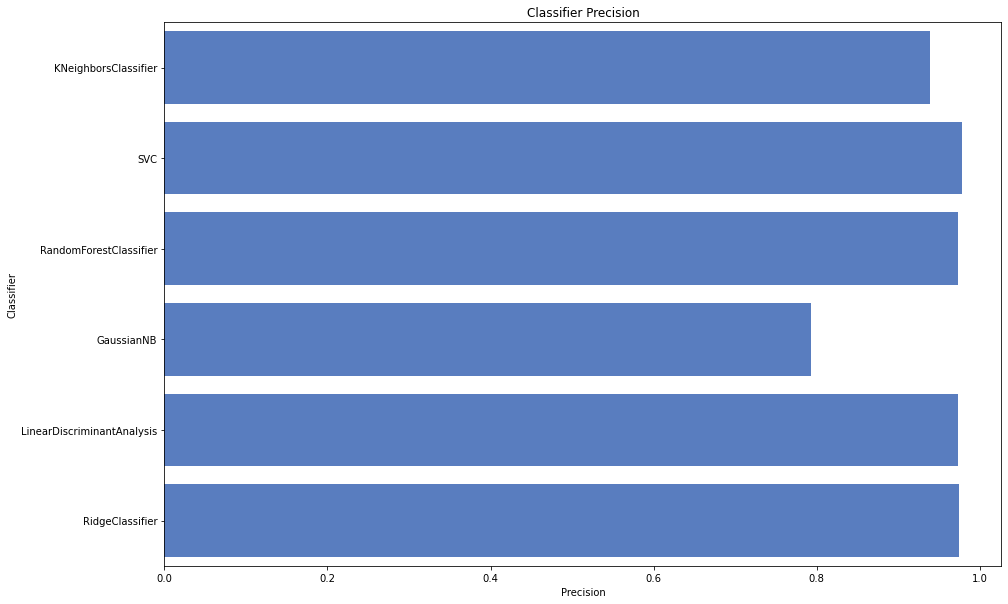

In [24]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
plt.xlabel('Precision')
plt.title('Classifier Precision')
sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=log, color="b",ax=ax)
fig.savefig("model.png")

# Final Model

After carefully tuning hyper parameters of various models, we found the best working model for each classifier.

* As can be seen from above results, Ridge and Linear Discriminant analyser are performing better than other models.
* Ensemble methods - As our data is heavily imbalanced, they suffer from having less data to classify the minority customer category of 1.
* SGD Classifier and SVM produced results that are heavily based on random state variable which is not a good sign.
* Finally zeroed upon Ridge Classifier and Linear Discriminant classifier
* Linear Discriminant Classifier doesn't have significant hyperparameters to tune. 
* With Ridge Classifier, the following parameters seemed to produce best results. 
> Ridge Classifier + Normalize data + "saga" solver + alpha =2.5






In [25]:
from sklearn.linear_model import RidgeClassifier
rc=RidgeClassifier(solver ="saga",normalize=True,alpha = 2.5)
rc.fit(X,Y)
Y_test=rc.predict(X_test)
submission['customer_category']= Y_test
submission.to_csv('submission.csv',index=False)
submission['customer_category'].describe()

count    7160.000000
mean        0.020670
std         0.142288
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: customer_category, dtype: float64

# Hyper Parameter Tuning

Below is the hyper parameter tuning that I have done. Most of the code is not very well organised as some of the hyper parameters are tuned by modifying the existing code. For XG Boost hyper parameter tuning, check version 1.

## Linear Discriminant Analysis

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda=LinearDiscriminantAnalysis(solver='eigen')
lda.fit(X,Y)
Y_test=lda.predict(X_test)
submission['customer_category_lda']= Y_test
submission['customer_category_lda'].describe()

count    7160.000000
mean        0.038268
std         0.191856
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: customer_category_lda, dtype: float64

## Ridge Classifier

In [27]:
from sklearn.linear_model import RidgeCV
regr_cv = RidgeCV(alphas=[0.1, 1.0, 10.0])
model_cv = regr_cv.fit(X, Y)
model_cv.alpha_

0.1

In [28]:
from sklearn.linear_model import RidgeClassifier
rc=RidgeClassifier(solver ="saga")
rc.fit(X,Y)
Y_test=rc.predict(X_test)
submission['customer_category']= Y_test
submission['customer_category'].describe()


count    7160.000000
mean        0.033380
std         0.179639
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: customer_category, dtype: float64

## Random Forest

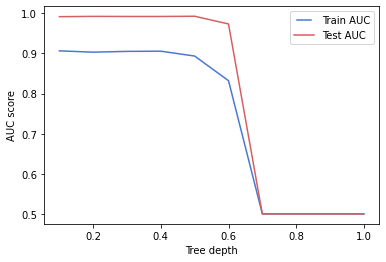

In [29]:

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(n_estimators=150,min_samples_split=min_samples_split)
    rf.fit(X_train, Y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    Y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, Y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results,'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150,max_depth=2,min_samples_split=0.4,random_state=0)
rf.fit(X,Y)
Y_test=rf.predict(X_test)
submission['customer_category_rfc']= Y_test
submission['customer_category_rfc'].describe()

count    7160.000000
mean        0.039385
std         0.194524
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: customer_category_rfc, dtype: float64

In [31]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=4)
sgd.fit(X,Y)
Y_test=sgd.predict(X_test)
submission['customer_category_sgd']= Y_test
submission['customer_category_sgd'].describe()

count    7160.000000
mean        0.087291
std         0.282280
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: customer_category_sgd, dtype: float64

In [32]:
"""
submission["customer_category"]=((submission["customer_category_rc0"]+submission["customer_category_rc1"]+submission["customer_category_lda"]
                                  +submission["customer_category_rfc"])>2).astype(int)
sub = submission[["customer_id","customer_category"]]
"""

'\nsubmission["customer_category"]=((submission["customer_category_rc0"]+submission["customer_category_rc1"]+submission["customer_category_lda"]\n                                  +submission["customer_category_rfc"])>2).astype(int)\nsub = submission[["customer_id","customer_category"]]\n'